### Sentiment classification with Random Flips

In [1]:
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from util import load_directory_data,load_dataset,download_and_load_datasets,gpusession,random_flip_target
from cn_cls_class import cn_cls_class
from mlp_cls_class import mlp_cls_class
print ("Packages loaded.")

Packages loaded.


### Get feature

In [2]:
dataset_name = 'movie_review'

In [3]:
savename = 'data/' + dataset_name + '.npz'
FORCE_RELOAD = 0 
if os.path.isfile(savename) & (~FORCE_RELOAD): # load if the file exists,
    # Load 
    l = np.load(savename)    
    x_train = l['x_train']
    x_test = l['x_test']
    t_train = l['t_train']
    t_test = l['t_test']
    print ("[%s] Loaded. Size is [%.4f]MB" % (savename,os.path.getsize(savename)/1000./1000.))
else: # otherwise, make the data
    # Download dataset
    tf.logging.set_verbosity(tf.logging.ERROR) # Reduce logging output.
    train_df, test_df = download_and_load_datasets()
    # Check dataset
    for i in range(2):
        print (i,':',train_df['sentence'][i],'\n')
    for i in range(2):
        print (i,':',train_df['polarity'][i])
    embed_module = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1")
    embed_train = embed_module(tf.reshape(train_df["sentence"], shape=[-1]))
    embed_test = embed_module(tf.reshape(test_df["sentence"], shape=[-1]))
    with tf.train.MonitoredTrainingSession(is_chief=True) as sess:
        x_train = sess.run(embed_train)
        x_test = sess.run(embed_test)
    n_train,n_test = np.shape(x_train)[0],np.shape(x_test)[0]
    t_train,t_test = np.zeros((n_train,2)),np.zeros((n_test,2))
    for i in range(n_train):
        t_train[i,train_df['polarity'][i]] = 1
    for i in range(n_test):
        t_test[i,test_df['polarity'][i]] = 1    
    print("Shapes of 'x_train' and 'x_test' are %s and %s."%
          (x_train.shape,x_test.shape)) # (result: (1, 128))    
    print("Shapes of 't_train' and 't_test' are %s and %s."%
          (t_train.shape,t_test.shape)) # (result: (1, 128))    
    # Save 
    np.savez(savename,x_train=x_train,x_test=x_test,t_train=t_train,t_test=t_test)
    print ("[%s] Saved. Size is [%.4f]MB" % (savename,os.path.getsize(savename)/1000./1000.))

[data/movie_review.npz] Loaded. Size is [26.4009]MB


### Run

In [4]:
VERBOSE = 0
r_seeds = [0]
rates = [0.0,0.1,0.2,0.3,0.4]

lr = 1e-4
max_epoch = 10
batch_size = 256
LR_SCHEDULE = 0

mix_train_accrs,mix_test_accrs = np.zeros((len(rates),len(r_seeds))),np.zeros((len(rates),len(r_seeds)))
cn_train_accrs,cn_test_accrs = np.zeros((len(rates),len(r_seeds))),np.zeros((len(rates),len(r_seeds)))
mlp_train_accrs,mlp_test_accrs = np.zeros((len(rates),len(r_seeds))),np.zeros((len(rates),len(r_seeds)))
for s_idx,r_seed in enumerate(r_seeds):
    for r_idx,rate in enumerate(rates):
        # Add perturbation to t_label
        t_train_shuffle = random_flip_target(t_train,_rate=rate,_seed=r_seed)
        # Run MIXUP
        tf.reset_default_graph(); tf.set_random_seed(0)
        MIX = mlp_cls_class(_name='mix_cls_sentiment_%02derr_seed%d'%(rate*100,r_seed),_x_dim=128,_t_dim=2,_h_dims=[128,128],
                        _actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-6,_momentum=0.5,
                        _USE_SGD=False,_USE_MIXUP=True,_GPU_ID=0,_VERBOSE=VERBOSE)
        sess = gpusession();sess.run(tf.global_variables_initializer()) 
        MIX.train(sess,_x_train=x_train,_t_train=t_train_shuffle,_x_test=x_test,_t_test=t_test,
                      _max_epoch=max_epoch,_batch_size=batch_size,_lr=lr,_kp=0.95,
                      _LR_SCHEDULE=LR_SCHEDULE,_PRINT_EVERY=10,_VERBOSE_TRAIN=True)
        # Run ChoiceNet
        tf.reset_default_graph(); tf.set_random_seed(0)
        CN = cn_cls_class(_name='cn_cls_sentiment_%02derr_seed%d'%(rate*100,r_seed),_x_dim=128,_t_dim=2,_h_dims=[128,128],
                          _k_mix=10,_rho_ref_train=0.95,_tau_inv=1e-4,_pi1_bias=0.1,
                          _log_sigma_z_val=-2,_logsumexp_coef=1e-4,_kl_reg_coef=1e-4,
                          _actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-6,_momentum=0.5,
                          _USE_SGD=False,_USE_MIXUP=False,_GPU_ID=0,_VERBOSE=VERBOSE)
        sess = gpusession();sess.run(tf.global_variables_initializer()) 
        CN.train(sess,_x_train=x_train,_t_train=t_train_shuffle,_x_test=x_test,_t_test=t_test,
                      _max_epoch=max_epoch,_batch_size=batch_size,_lr=lr,_kp=0.95,
                      _LR_SCHEDULE=LR_SCHEDULE,_PRINT_EVERY=10,_VERBOSE_TRAIN=True)
        # Run MLP
        tf.reset_default_graph(); tf.set_random_seed(0)
        MLP = mlp_cls_class(_name='mlp_cls_sentiment_%02derr_seed%d'%(rate*100,r_seed),_x_dim=128,_t_dim=2,_h_dims=[128,128],
                        _actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-6,_momentum=0.5,
                        _USE_SGD=False,_USE_MIXUP=False,_GPU_ID=0,_VERBOSE=VERBOSE)
        sess = gpusession();sess.run(tf.global_variables_initializer()) 
        MLP.train(sess,_x_train=x_train,_t_train=t_train_shuffle,_x_test=x_test,_t_test=t_test,
                      _max_epoch=max_epoch,_batch_size=batch_size,_lr=lr,_kp=0.95,
                      _LR_SCHEDULE=LR_SCHEDULE,_PRINT_EVERY=10,_VERBOSE_TRAIN=True)
        # Append
        mix_train_accrs[r_idx,s_idx],mix_test_accrs[r_idx,s_idx] = MIX.train_accr,MIX.test_accr
        cn_train_accrs[r_idx,s_idx],cn_test_accrs[r_idx,s_idx] = CN.train_accr,CN.test_accr
        mlp_train_accrs[r_idx,s_idx],mlp_test_accrs[r_idx,s_idx] = MLP.train_accr,MLP.test_accr
        # Print
        print ("\nSeed:[%d] Err:[%d%%] MIXUP tr:%.4f te:%.4f ChoiceNet tr:%.4f te:%.4f MLP tr:%.4f te:%.4f\n"%
               (r_seed,rate*100,MIX.train_accr,MIX.test_accr,CN.train_accr,CN.test_accr,MLP.train_accr,MLP.test_accr))
print ("Done.")

Text name: res/res_mix_cls_sentiment_00err_seed0.txt
[00/10] [Loss] train:0.466 test:0.474 [Accr] train:79.6% test:78.7% maxTest:78.7%
[01/10] [Loss] train:0.443 test:0.457 [Accr] train:80.1% test:78.8% maxTest:78.8%
[02/10] [Loss] train:0.437 test:0.452 [Accr] train:80.8% test:79.5% maxTest:79.5%
[03/10] [Loss] train:0.438 test:0.454 [Accr] train:80.8% test:79.4% maxTest:79.5%
[04/10] [Loss] train:0.437 test:0.453 [Accr] train:80.6% test:79.1% maxTest:79.5%
[05/10] [Loss] train:0.432 test:0.451 [Accr] train:81.0% test:79.3% maxTest:79.5%
[06/10] [Loss] train:0.437 test:0.456 [Accr] train:80.9% test:79.1% maxTest:79.5%
[07/10] [Loss] train:0.428 test:0.450 [Accr] train:81.0% test:79.3% maxTest:79.5%
[08/10] [Loss] train:0.420 test:0.447 [Accr] train:82.1% test:79.8% maxTest:79.8%
[09/10] [Loss] train:0.422 test:0.448 [Accr] train:82.1% test:79.9% maxTest:79.9%
[10/10] [Loss] train:0.410 test:0.440 [Accr] train:82.2% test:79.8% maxTest:79.9%
Training finished.
Text name: res/res_cn_cls_

[02/10] [Loss] train:0.596 test:0.501 [Accr] train:69.3% test:78.5% maxTest:78.5%
[03/10] [Loss] train:0.589 test:0.505 [Accr] train:70.0% test:78.3% maxTest:78.5%
[04/10] [Loss] train:0.578 test:0.499 [Accr] train:70.8% test:78.6% maxTest:78.6%
[05/10] [Loss] train:0.569 test:0.490 [Accr] train:71.4% test:78.4% maxTest:78.6%
[06/10] [Loss] train:0.570 test:0.510 [Accr] train:70.9% test:76.6% maxTest:78.6%
[07/10] [Loss] train:0.555 test:0.500 [Accr] train:72.0% test:76.9% maxTest:78.6%
[08/10] [Loss] train:0.535 test:0.498 [Accr] train:73.8% test:77.5% maxTest:78.6%
[09/10] [Loss] train:0.532 test:0.523 [Accr] train:74.0% test:75.7% maxTest:78.6%
[10/10] [Loss] train:0.521 test:0.517 [Accr] train:74.5% test:75.7% maxTest:78.6%
Training finished.

Seed:[0] Err:[20%] MIXUP tr:0.6950 te:0.7757 ChoiceNet tr:0.7242 te:0.7867 MLP tr:0.7450 te:0.7570

Text name: res/res_mix_cls_sentiment_30err_seed0.txt
[00/10] [Loss] train:0.664 test:0.598 [Accr] train:61.2% test:74.2% maxTest:74.2%
[01/10]

In [5]:
if False:
    save_name = 'data/res_sentiment_flip.npz'
    np.savez(save_name,
             mix_train_accrs=mix_train_accrs,mix_test_accrs=mix_test_accrs,
             cn_train_accrs=cn_train_accrs,cn_test_accrs=cn_test_accrs,
             mlp_train_accrs=mlp_train_accrs,mlp_test_accrs=mlp_test_accrs,
             rates=rates)
    print ("[%s] Saved. Size is [%.4f]MB" % (save_name,os.path.getsize(save_name)/1000./1000.))

[data/res_sentiment_flip.npz] Saved. Size is [0.0020]MB


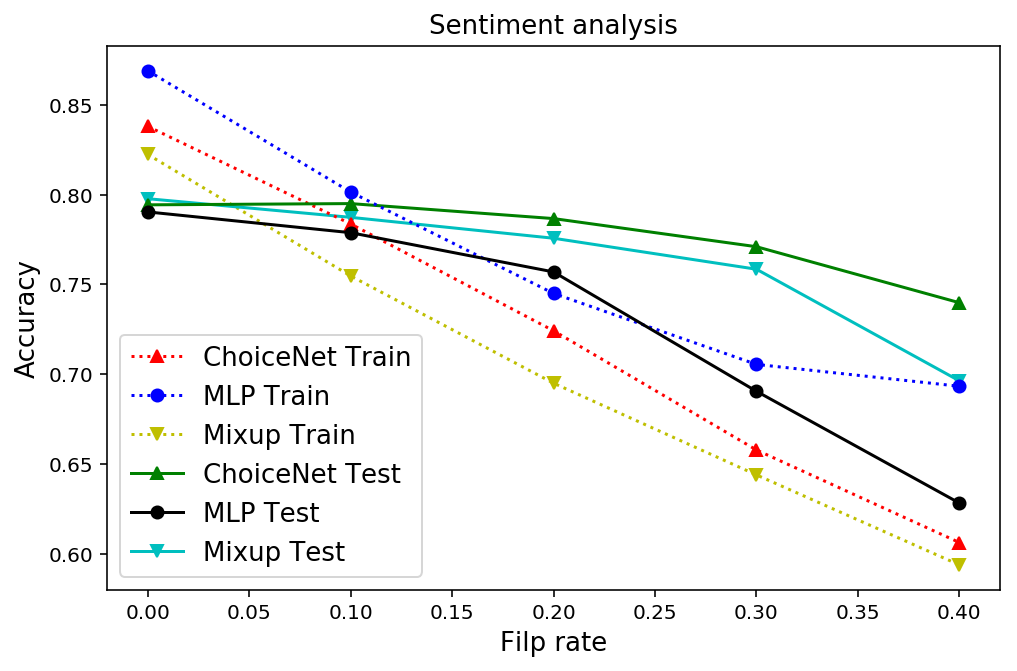

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

load_name = 'data/res_sentiment_flip.npz'
l = np.load(load_name)
mix_train_accrs = l['mix_train_accrs']
mix_test_accrs = l['mix_test_accrs']
cn_train_accrs = l['cn_train_accrs']
cn_test_accrs = l['cn_test_accrs']
mlp_train_accrs = l['mlp_train_accrs']
mlp_test_accrs = l['mlp_test_accrs']
rates = l['rates']

plt.figure(figsize=(8,5))

h_mix_tr,=plt.plot(rates,mix_train_accrs.mean(axis=1),'yv:')
h_mix_te,=plt.plot(rates,mix_test_accrs.mean(axis=1),'cv-')

h_cn_tr,=plt.plot(rates,cn_train_accrs.mean(axis=1),'r^:')
h_cn_te,=plt.plot(rates,cn_test_accrs.mean(axis=1),'g^-')

h_mlp_tr,=plt.plot(rates,mlp_train_accrs.mean(axis=1),'bo:')
h_mlp_te,=plt.plot(rates,mlp_test_accrs.mean(axis=1),'ko-')

plt.legend([h_cn_tr,h_mlp_tr,h_mix_tr,h_cn_te,h_mlp_te,h_mix_te],
           ['ChoiceNet Train','MLP Train','Mixup Train','ChoiceNet Test','MLP Test','Mixup Test'],fontsize=13)
plt.xlabel('Filp rate',fontsize=13)
plt.ylabel('Accuracy',fontsize=13)
plt.title('Sentiment analysis',fontsize=13)
plt.show()

In [10]:
print ('rates',rates)
print ('mix_test_accrs',mix_test_accrs.squeeze())
print ('cn_test_accrs',cn_test_accrs.squeeze())
print ('mlp_test_accrs',mlp_test_accrs.squeeze())

rates [0.  0.1 0.2 0.3 0.4]
mix_test_accrs [0.79772949 0.78735352 0.77571615 0.75846354 0.69632975]
cn_test_accrs [0.79431152 0.79500326 0.78666178 0.77099609 0.73982747]
mlp_test_accrs [0.79036458 0.77880859 0.75695801 0.69051107 0.6282959 ]
